In [1]:
import datasets
import numpy as np
import pandas as pd
dl_manager = datasets.DownloadManager()
_DOWNLOAD_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip'
archive = dl_manager.download(_DOWNLOAD_URL)

In [2]:
for path, f in dl_manager.iter_archive(archive):
    if path[-3:] == 'csv':
        df = pd.read_csv(f)

In [6]:
df.shape[0] - 31686 - 7922

36

In [5]:
31686 + 7922

39608

In [3]:
df.columns = df.columns.str.strip()

<AxesSubplot:>

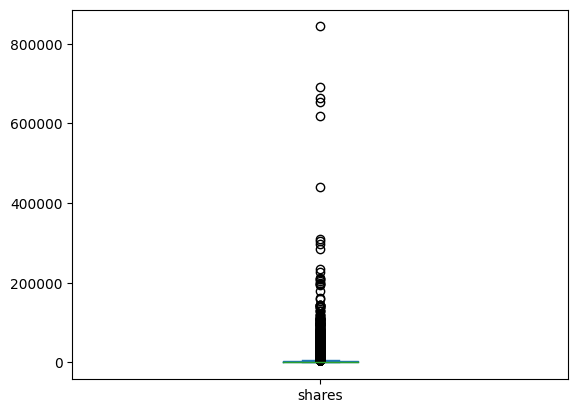

In [4]:
df.shares.plot.box()

In [5]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df.iloc[:, 1:], minimal = True)
# profile

# Findings

* n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens should be between 0 and 1, because they are proportions +

* Check if data_channel_is_* are non-overlaping variables +
    - convert them to a categorical variable

* "num_keywords" indicates how many key words in the article; related variables are kw\_\*\_\* where * $\in$ {min,avg,max} +
    - When they are -1, it needs to be converted to 0
    
* "num_self_hrefs" indicates how many Marshable's own articles are linked in the article; related variables are self_reference_\*\_shares
    
* weekday_is_\* and is_weekend can be treated as a single categorical variable

* By its proximity to LDA_00, ..., LDA_04, it can be treated as a categotical variable

* polarity is between -1 and 1 (negative is between -1 and 0; positive is between 0 and 1)

* subjectivity is between 0 and 1

In [6]:
# n_unique_tokens
df.n_unique_tokens.lt(0).sum(), df.n_unique_tokens.gt(1).sum()

(0, 1)

In [7]:
# n_non_stop_words
df.n_non_stop_words.lt(0).sum(), df.n_non_stop_words.gt(1).sum()

(0, 1)

In [8]:
# n_non_stop_words
df.n_non_stop_unique_tokens.lt(0).sum(), df.n_non_stop_unique_tokens.gt(1).sum()

(0, 1)

In [9]:
df = df.loc[df.n_unique_tokens.le(1),:].reset_index(drop = True)

In [10]:
data_channel = df.loc[:, df.columns.str.contains("data_channel_is_*")]

In [11]:
#data_channel_is_* variables are not overlapping!
data_channel.T.dot(data_channel)

,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world
data_channel_is_lifestyle,2099.0,0.0,0.0,0.0,0.0,0.0
data_channel_is_entertainment,0.0,7056.0,0.0,0.0,0.0,0.0
data_channel_is_bus,0.0,0.0,6258.0,0.0,0.0,0.0
data_channel_is_socmed,0.0,0.0,0.0,2323.0,0.0,0.0
data_channel_is_tech,0.0,0.0,0.0,0.0,7346.0,0.0
data_channel_is_world,0.0,0.0,0.0,0.0,0.0,8427.0


In [12]:
# Some observations don't fall into any of them
data_channel.T.dot(data_channel).sum().sum(), df.shape[0]

(33509.0, 39643)

In [13]:
def define_channel(seq):
    """
    0 : lifestyle
    1 : entertainment
    2 : bus
    3 : socmed
    4 : tech
    5 : world
    6 : none
    """
    if seq.sum():
        return np.where(seq == 1)[0][0]
    else:
        return 6
        

In [14]:
df.loc[:, 'channel'] = df.loc[:, df.columns.str.contains("data_channel_is_*")].apply(define_channel, axis = 1)

In [15]:
df = df.drop(df.columns[df.columns.str.contains("data_channel_is_*")], axis = 1)

In [16]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,channel
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,1
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,2
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,2
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,1
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,4


In [17]:
# replacing -1 in kw_*_* to 0
df = df.replace({colname: {-1:0} for colname in df.columns[df.columns.str.contains('kw_\w+_\w+')]})

In [18]:
# No Monday, Thursday, or Friday weekend
week = df.loc[:, df.columns.str.contains('week')]
week.T.dot(week)

,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend
weekday_is_monday,6661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weekday_is_tuesday,0.0,7389.0,0.0,0.0,0.0,0.0,0.0,0.0
weekday_is_wednesday,0.0,0.0,7435.0,0.0,0.0,0.0,0.0,0.0
weekday_is_thursday,0.0,0.0,0.0,7267.0,0.0,0.0,0.0,0.0
weekday_is_friday,0.0,0.0,0.0,0.0,5701.0,0.0,0.0,0.0
weekday_is_saturday,0.0,0.0,0.0,0.0,0.0,2453.0,0.0,2453.0
weekday_is_sunday,0.0,0.0,0.0,0.0,0.0,0.0,2737.0,2737.0
is_weekend,0.0,0.0,0.0,0.0,0.0,2453.0,2737.0,5190.0


In [19]:
# no missing
df.loc[:, df.columns.str.contains('weekday')].sum().sum() == df.shape[0]

True

In [20]:
df.loc[:, "weekday"] = df.loc[:, df.columns.str.contains('weekday')].apply(lambda x: np.where(x == 1)[0][0], axis = 1)

In [21]:
df = df.drop(df.columns[df.columns.str.contains('weekday_') | df.columns.str.contains('weekend')], axis = 1)

In [22]:
# We don't need to transform LDA as it indicates the probability each observation falls into 

In [23]:
df.loc[:, 'LDA'] = df.loc[:, df.columns.str.contains('LDA')].apply(lambda x: 'LDA_0' + str(np.where(x == max(x))[0][0]), axis = 1)

In [24]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_pola

<AxesSubplot:title={'center':'shares'}, xlabel='[LDA]'>

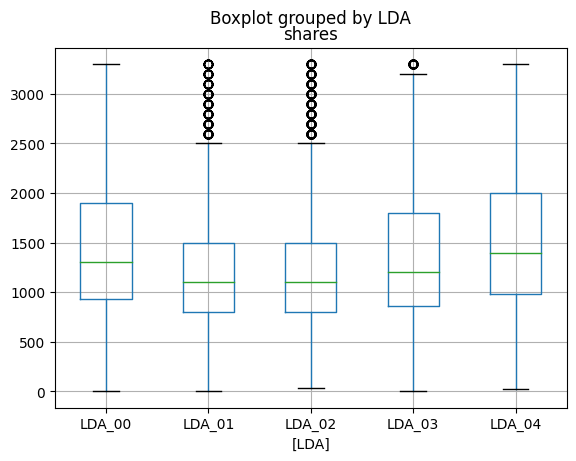

In [25]:
df.loc[df.shares.lt(df.shares.quantile(.8)),['LDA','shares']].boxplot(by = 'LDA')

In [26]:
lda = df.loc[:, df.columns.str.contains('LDA_')]
lda.T.dot(lda)

,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04
LDA_00,4092.480323,622.965962,831.402778,792.584111,978.811497
LDA_01,622.965962,2704.643957,641.946437,940.301129,690.086385
LDA_02,831.402778,641.946437,5010.948823,833.921628,1257.608741
LDA_03,792.584111,940.301129,833.921628,5439.482373,864.833437
LDA_04,978.811497,690.086385,1257.608741,864.833437,5486.520317


In [27]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_pola

In [28]:
df.n_unique_tokens 

0        0.663594
1        0.604743
2        0.575130
3        0.503788
4        0.415646
           ...   
39638    0.529052
39639    0.696296
39640    0.516355
39641    0.539493
39642    0.701987
Name: n_unique_tokens, Length: 39643, dtype: float64

<AxesSubplot:>

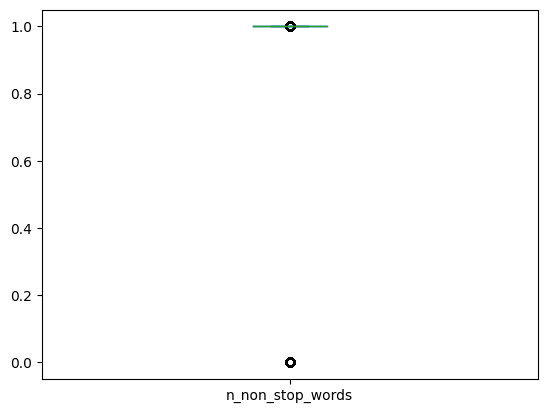

In [29]:
df.n_non_stop_words.plot.box()

<AxesSubplot:>

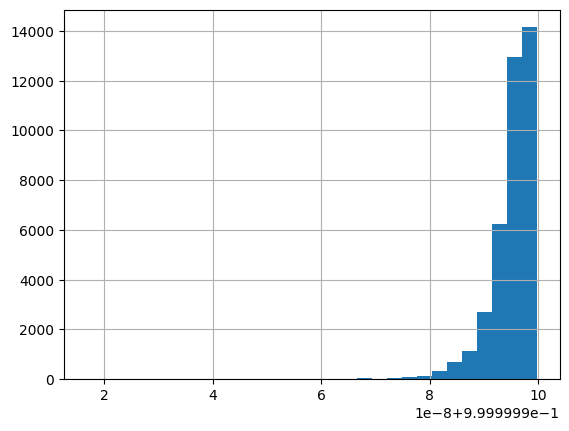

In [30]:
df.n_non_stop_words[df.n_non_stop_words.gt(.8)].hist(bins = 30)

In [31]:
df.n_non_stop_words.round(3).value_counts()

1.0    38462
0.0     1181
Name: n_non_stop_words, dtype: int64

In [32]:
# if n_tokens_content is 0, df.n_non_stop_words is 0
df.loc[df.n_non_stop_words.round(3).eq(0)].n_tokens_content.mean()

0.0

In [33]:
(df.n_non_stop_words.round(3).eq(0) * df.n_tokens_content.gt(0)).sum()

0

In [34]:
df = df.drop('n_non_stop_words', axis = 1)

In [50]:
df['shares_class'] = df.shares.apply(lambda x: x>1400)

In [53]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'shares', 'ch

In [36]:
# df = df[['n_tokens_title', 'n_tokens_content',
#        'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs',
#        'num_imgs', 'num_videos', 'average_token_length',
#        'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
#        'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
#        'num_self_hrefs', 'self_reference_min_shares', 'self_reference_max_shares',
#        'self_reference_avg_sharess', 'LDA', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
#        'LDA_04',  'global_subjectivity', 'title_subjectivity', 'abs_title_subjectivity',
#        'global_sentiment_polarity',
#        'global_rate_positive_words', 'global_rate_negative_words',
#        'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
#        'min_positive_polarity', 'max_positive_polarity',
#        'avg_negative_polarity', 'min_negative_polarity',
#        'max_negative_polarity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity',
#        'channel','weekday', 'shares']]

In [54]:
df.drop(['url','timedelta','LDA','shares'], axis = 1).to_csv('text_summary_stats.csv', 
                                                             index = False)